<a href="https://colab.research.google.com/github/jwengr/dacon/blob/main/%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EC%82%AC%EC%9A%A9%EC%9E%90%20%EC%97%B0%EC%B2%B4%20%EC%98%88%EC%B8%A1%20AI%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/WideDeepNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda
from itertools import combinations
from transformers import BertTokenizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [43]:
PATH = 'drive/My Drive/dacon/credit'

In [44]:
train_df = pd.read_csv(PATH+'/dataset/train.csv').drop(['index','FLAG_MOBIL'],axis=1)
test_df = pd.read_csv(PATH+'/dataset/test.csv').drop(['index','FLAG_MOBIL'],axis=1)

In [45]:
train_df,val_df = train_test_split(train_df,test_size=0.2,stratify=train_df['credit'])

In [46]:
train_df['occyp_type'].fillna('one two three',inplace=True)
val_df['occyp_type'].fillna('one two three',inplace=True)
test_df['occyp_type'].fillna('one two three',inplace=True)

In [47]:
train_df['not_employed'] = (train_df['DAYS_EMPLOYED']>0).astype(np.int32)
val_df['not_employed'] = (val_df['DAYS_EMPLOYED']>0).astype(np.int32)
test_df['not_employed'] = (test_df['DAYS_EMPLOYED']>0).astype(np.int32)

In [48]:
train_df['begin_months'] = train_df['begin_month'].values%12
val_df['begin_months'] = val_df['begin_month'].values%12
test_df['begin_months'] = test_df['begin_month'].values%12

In [49]:
le = LabelEncoder()

In [50]:
for col in ['gender','car','reality','work_phone','phone','email','not_employed','begin_months']:
    le.fit(train_df[[col]])
    train_df[[col]] = le.transform(train_df[[col]]).astype(np.int32)
    train_df = pd.concat([train_df,pd.get_dummies(train_df[col],prefix=f'{col}')],axis=1)

    val_df[[col]] = le.transform(val_df[[col]]).astype(np.int32)
    val_df = pd.concat([val_df,pd.get_dummies(val_df[col],prefix=f'{col}')],axis=1)

    test_df[[col]] = le.transform(test_df[[col]]).astype(np.int32)
    test_df = pd.concat([test_df,pd.get_dummies(test_df[col],prefix=f'{col}')],axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
train_df.shape,val_df.shape,test_df.shape

((21165, 46), (5292, 46), (10000, 45))

In [52]:
for col in ['income_type','edu_type','family_type','house_type','occyp_type']:
    train_df = pd.concat([train_df,pd.get_dummies(train_df[col],prefix=f'{col}')],axis=1)
    val_df = pd.concat([val_df,pd.get_dummies(val_df[col],prefix=f'{col}')],axis=1)
    test_df = pd.concat([test_df,pd.get_dummies(test_df[col],prefix=f'{col}')],axis=1)

In [53]:
dummies_df = train_df.iloc[:,34:]
train_df = train_df.iloc[:,:34]

val_dummies_df = val_df.iloc[:,34:]
val_df = val_df.iloc[:,:34]

test_dummies_df = pd.DataFrame(columns=dummies_df.columns)
for col in test_df.iloc[:,33:].columns:
    test_dummies_df[col] = test_df[col]
test_dummies_df.fillna(0,inplace=True)
test_df = test_df.iloc[:,:33]

In [54]:
dummies_arr = dummies_df.values
val_dummies_arr = val_dummies_df.values
test_dummies_arr = test_dummies_df.values

In [55]:
dummies_arr.shape,val_dummies_arr.shape,test_dummies_arr.shape

((21165, 52), (5292, 52), (10000, 52))

In [56]:
wide_arr = np.zeros((len(train_df),dummies_arr.shape[1]*(dummies_arr.shape[1]-1)//2),dtype=np.int32)
val_wide_arr = np.zeros((len(val_df),val_dummies_arr.shape[1]*(val_dummies_arr.shape[1]-1)//2),dtype=np.int32)
test_wide_arr = np.zeros((len(test_df),test_dummies_arr.shape[1]*(test_dummies_arr.shape[1]-1)//2),dtype=np.int32)

In [57]:
i=0
for a,b in list(combinations(range(dummies_arr.shape[1]),2)):
    wide_arr[:,i] = dummies_arr[:,a]*dummies_arr[:,b]
    val_wide_arr[:,i] = val_dummies_arr[:,a]*val_dummies_arr[:,b]
    test_wide_arr[:,i] = test_dummies_arr[:,a]*test_dummies_arr[:,b]
    i+=1

In [58]:
test_wide_arr = test_wide_arr[:,np.sum(wide_arr,axis=0)!=0]
val_wide_arr = val_wide_arr[:,np.sum(wide_arr,axis=0)!=0]
wide_arr = wide_arr[:,np.sum(wide_arr,axis=0)!=0]

In [59]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [60]:
print('----train----')
for col in ['income_type','edu_type','family_type','house_type','occyp_type']:
    print(col,max([len(tokenizer.encode(val)) for val in set(train_df[col].values)]))
print('----test----')
for col in ['income_type','edu_type','family_type','house_type','occyp_type']:
    print(col,max([len(tokenizer.encode(val)) for val in set(test_df[col].values)]))

----train----
income_type 4
edu_type 6
family_type 6
house_type 6
occyp_type 8
----test----
income_type 4
edu_type 6
family_type 6
house_type 6
occyp_type 8


In [61]:
emb_arr = np.zeros((len(train_df),3+5+5+5+7),np.int32)
val_emb_arr = np.zeros((len(val_df),3+5+5+5+7),np.int32)
test_emb_arr = np.zeros((len(test_df),3+5+5+5+7),np.int32)

In [62]:
last=0
for col,max_length in zip(['income_type','edu_type','family_type','house_type','occyp_type'],[4,6,6,6,8]):
    emb_arr[:,last:last+max_length-1] = np.array(train_df[col].apply(lambda x: tokenizer.encode_plus(x,padding='max_length',max_length=max_length)['input_ids'][1:]).values.tolist())
    val_emb_arr[:,last:last+max_length-1] = np.array(val_df[col].apply(lambda x: tokenizer.encode_plus(x,padding='max_length',max_length=max_length)['input_ids'][1:]).values.tolist())
    test_emb_arr[:,last:last+max_length-1] = np.array(test_df[col].apply(lambda x: tokenizer.encode_plus(x,padding='max_length',max_length=max_length)['input_ids'][1:]).values.tolist())
    last+=max_length-1

In [63]:
for col in ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','family_size','begin_month']:
    scaler = StandardScaler()
    scaler.fit(train_df[[col]])
    train_df[f'{col}_scaled'] = scaler.transform(train_df[[col]])
    val_df[f'{col}_scaled'] = scaler.transform(val_df[[col]])
    test_df[f'{col}_scaled'] = scaler.transform(test_df[[col]])

In [64]:
deep_arr = train_df[['gender','car','reality','child_num','work_phone','phone','email',
          'income_total_scaled','DAYS_BIRTH_scaled','DAYS_EMPLOYED_scaled','family_size_scaled','begin_month_scaled']].values
val_deep_arr = val_df[['gender','car','reality','child_num','work_phone','phone','email',
          'income_total_scaled','DAYS_BIRTH_scaled','DAYS_EMPLOYED_scaled','family_size_scaled','begin_month_scaled']].values
test_deep_arr = test_df[['gender','car','reality','child_num','work_phone','phone','email',
          'income_total_scaled','DAYS_BIRTH_scaled','DAYS_EMPLOYED_scaled','family_size_scaled','begin_month_scaled']].values

In [65]:
deep_arr = np.concatenate((deep_arr,emb_arr),axis=1)
val_deep_arr = np.concatenate((val_deep_arr,val_emb_arr),axis=1)
test_deep_arr = np.concatenate((test_deep_arr,test_emb_arr),axis=1)

In [66]:
deep_arr.shape,wide_arr.shape,val_deep_arr.shape,val_wide_arr.shape,test_deep_arr.shape,test_wide_arr.shape,

((21165, 37), (21165, 929), (5292, 37), (5292, 929), (10000, 37), (10000, 929))

In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices(((np.concatenate((deep_arr,wide_arr),axis=1)),pd.get_dummies(train_df['credit'].astype(np.int32)).values)).shuffle(21165).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices(((np.concatenate((val_deep_arr,val_wide_arr),axis=1)),pd.get_dummies(val_df['credit'].astype(np.int32)).values)).shuffle(5292).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices(np.concatenate((test_deep_arr,test_wide_arr),axis=1)).batch(256)

In [76]:
inputs = keras.Input(shape=(deep_arr.shape[1]+wide_arr.shape[1]))
deep,wide = Lambda( lambda x: tf.split(x,num_or_size_splits=[deep_arr.shape[1],wide_arr.shape[1]],axis=1))(inputs)

deep = layers.BatchNormalization()(deep)
deep = layers.Dense(24,activation='relu')(deep)
deep = layers.Dense(3,activation='sigmoid')(deep)

wide = layers.Dense(3,activation='sigmoid')(wide)

x = layers.Concatenate()([deep,wide])
outputs = layers.Dense(3,activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile('Adam','categorical_crossentropy')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 966)]        0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               [(None, 37), (None,  0           input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 37)           148         lambda_8[0][0]                   
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 24)           912         batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [77]:
early_stop = EarlyStopping(monitor='val_loss', patience=20,verbose=1)
mc = ModelCheckpoint(PATH+'/model/wide_deep.h5', monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(train_dataset,
                        epochs=1000,
                        verbose=1,
                    callbacks=[early_stop, mc],
                    validation_data=val_dataset
                    )

Epoch 1/1000
83/83 [==============================] - 1s 8ms/step - loss: 1.2086 - val_loss: 0.9942
Epoch 2/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.9596 - val_loss: 0.9105
Epoch 3/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8964 - val_loss: 0.8861
Epoch 4/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8753 - val_loss: 0.8747
Epoch 5/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8659 - val_loss: 0.8643
Epoch 6/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8496 - val_loss: 0.8583
Epoch 7/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8455 - val_loss: 0.8544
Epoch 8/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8422 - val_loss: 0.8509
Epoch 9/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8389 - val_loss: 0.8478
Epoch 10/1000
83/83 [==============================] - 1s 6ms/step - loss: 0.8348 - val_loss: 0.8446

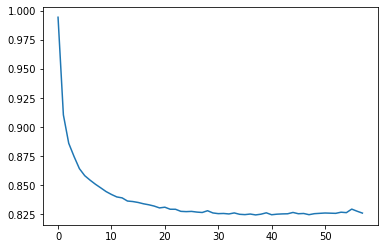

In [78]:
plt.plot(history.history['val_loss'])

In [79]:
saved_model = keras.models.load_model(PATH+'/model/wide_deep.h5')

In [80]:
submission = pd.read_csv(PATH+'/dataset/sample_submission.csv')

In [81]:
submission.iloc[:,1:] = model.predict(test_dataset)

In [82]:
submission.head(20)

,index,0,1,2
0,26457,0.122973,0.282639,0.594388
1,26458,0.216502,0.176179,0.607319
2,26459,0.096582,0.158606,0.744813
3,26460,0.101487,0.118627,0.779886
4,26461,0.154652,0.243553,0.601795
5,26462,0.083065,0.461729,0.455206
6,26463,0.218423,0.703154,0.078423
7,26464,0.142286,0.250896,0.606818
8,26465,0.099125,0.224253,0.676623
9,26466,0.152871,0.143743,0.703386


In [83]:
submission.to_csv(PATH+'/result/wide-deep6.csv',index=False)